In [1]:
%matplotlib notebook

In [1]:
%matplotlib notebook
from forced_barotropic_sphere.sphere import Sphere
from forced_barotropic_sphere.solver import Solver
from forced_barotropic_sphere.forcing import Forcing
#import bm_methods.bm_methods
import xarray as xr
import forced_barotropic_sphere.plotting as plotters
import forced_barotropic_sphere.ensemble_methods as ensemble_methods
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl          # Plotting routines
import matplotlib.pyplot as plt    
import matplotlib.animation as manim
import matplotlib.ticker as mticker
from IPython.display import display, clear_output, HTML, FileLink  # Some technical stuff, used to display animation
#from ipywidgets import FloatProgress
from ipykernel.pylab.backend_inline import flush_figures
import cartopy                   # Map projection stuff
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

/home/bertossa/miniconda3/envs/jupyter/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Find the climatological model spread by integrating a single run for a long time

integrating for  3650.0  days, with a dt of  0.046296296296296294  days


<IPython.core.display.Javascript object>


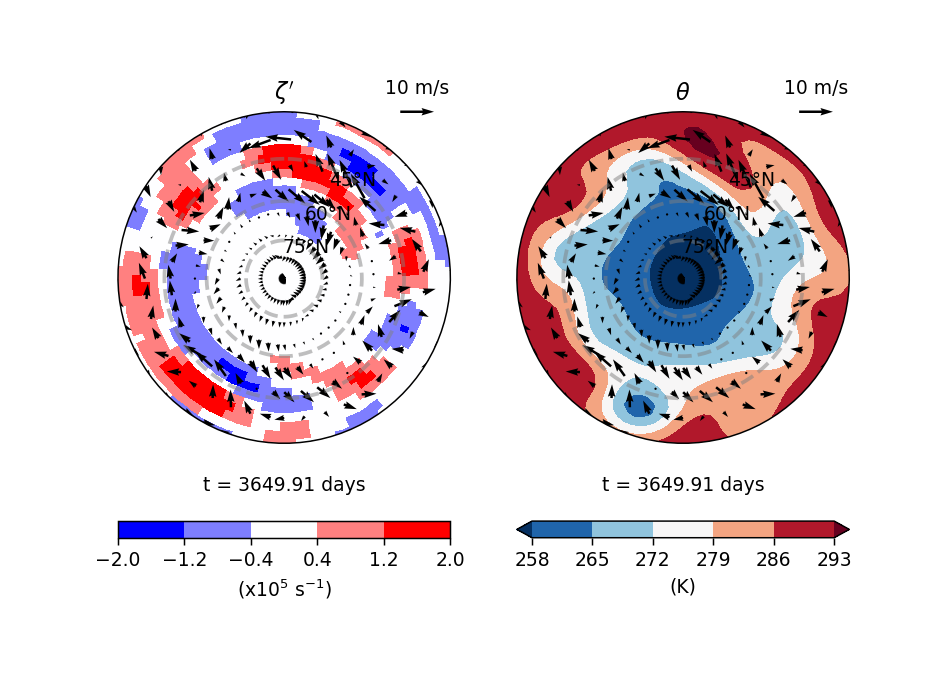

In [3]:
dt = 4000 #time between integration steps (seconds)
Nt = 7884*10 #number of integration steps (7884 = 1 yr)
T= Nt*dt #total integration time
print('integrating for ', T/86400, ' days, with a dt of ', dt/86400, ' days')

ofreq = 2

#T42 resolution
nlat=64; nlon=128

st = Sphere(nlat,nlon, U=0.)
F = Forcing(st,dt,T)
Si = F.generate_rededdy_start()
F.generate_rededdy_tseries(A=5e-12, Si=Si)

k0=6
vortp = 10e-5 * np.exp( -0.5 * (st.glats - 20.)**2 / 10**2 ) * np.cos(k0 * st.rlons)
thetap = np.zeros(vortp.shape)
vortp = np.zeros(thetap.shape)
ics = np.array([vortp,thetap])

sln = Solver(st, forcing=F, ofreq=ofreq).integrate_dynamics(temp_linear=True, vort_linear=True)
tidx=int(Nt/ofreq)-1
f,ax = plotters.plot_overview(sln.isel(time=tidx), levels=[np.linspace(-2,2,6),np.arange(258,300,7)], perturbation=[True,False])

<IPython.core.display.Javascript object>


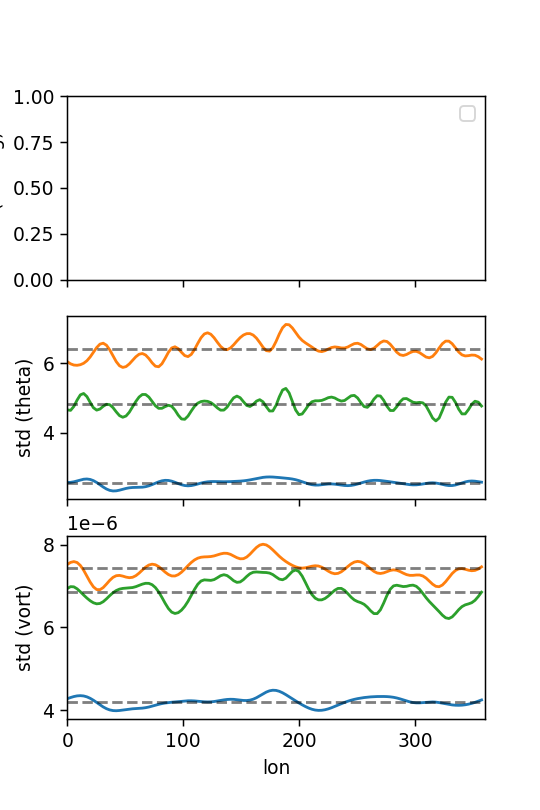

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [7]:
fig,axs = plt.subplots(3,1,figsize=(4,6),sharex=True)
lats = [20,50,65]

lats = [12,15,20]

for ll in lats:
    ll=int(ll)
    #axs[0].plot(sln.x.values,a[:,ll,:].std(axis=0),label= 'lat= '+str(round(sln.y.values[ll])))
    axs[1].plot(sln.x.values,sln.theta.isel(y=ll).std('time'))
    axs[1].axhline(sln.theta.isel(y=ll).std('time').mean(), linestyle='--', color='k',alpha=0.5)
    axs[2].plot(sln.x.values,sln.vort.isel(y=ll).std('time'))
    axs[2].axhline(sln.vortp.isel(y=ll).std('time').mean(), linestyle='--', color='k',alpha=0.5)
    
axs[0].set_xlim(0,360)
#axs[0].axvline(180)
axs[-1].set_xlabel('lon')
axs[0].set_ylabel('std (forcing)')
axs[1].set_ylabel('std (theta)')
axs[2].set_ylabel('std (vort)')
axs[0].legend()
plt.show()

<IPython.core.display.Javascript object>


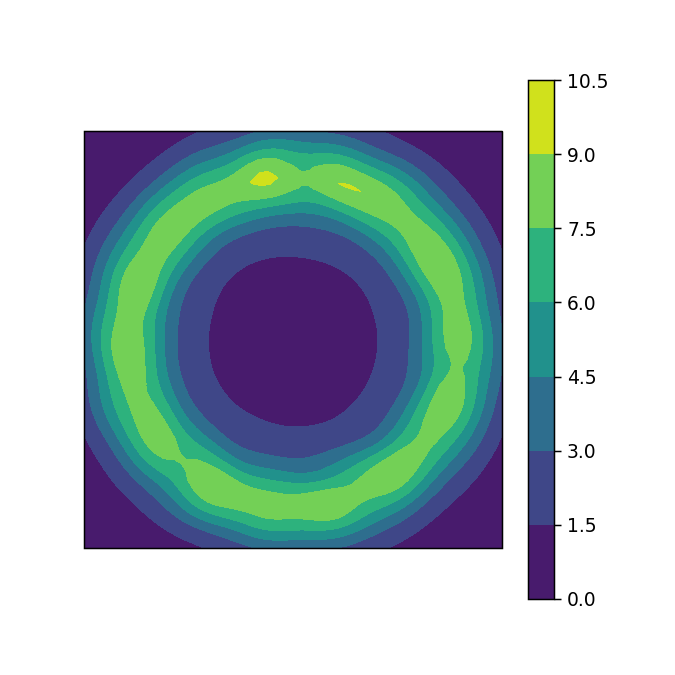

In [5]:
f = plt.figure(figsize = (5, 5))

proj=ccrs.NorthPolarStereo()
ax = plt.axes(projection=proj)
ax.set_extent([-179.9, 179.9, 30, 90], crs=ccrs.PlateCarree())
    
cyclic_data, cyclic_lons = cartopy.util.add_cyclic_point(sln.theta.std('time'), coord=sln.x.values)
cf= ax.contourf(cyclic_lons, sln.y.values, cyclic_data, transform=ccrs.PlateCarree())

# cyclic_data, cyclic_lons = cartopy.util.add_cyclic_point(sln.vort.std('time'), coord=sln.x.values)
# cf= ax.contourf(cyclic_lons, sln.y.values, cyclic_data, transform=ccrs.PlateCarree())

plt.colorbar(cf)
plt.show()

<IPython.core.display.Javascript object>


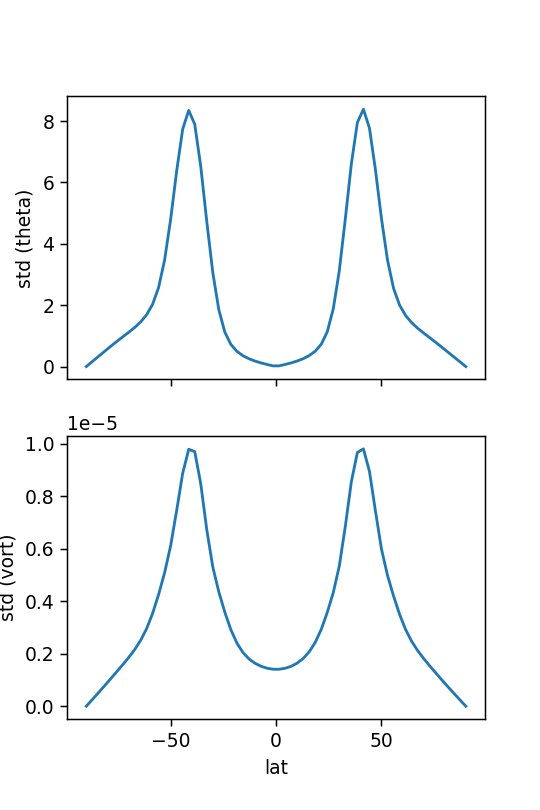

In [6]:
fig,axs = plt.subplots(2,1,figsize=(4,6),sharex=True)
axs[1].plot(sln.y.values,sln.vort.std('time').mean('x'))
axs[0].plot(sln.y.values,sln.theta.std('time').mean('x'))
axs[0].set_ylabel('std (theta)')
axs[1].set_ylabel('std (vort)')
plt.xlabel('lat')
plt.show()

In [9]:
clims = sln.std('time')#.mean('x')
clims.to_netcdf('../climatology.nc')

# Then, we can see if our ensemble has sufficient spread to produce the climatology

In [15]:
num_members= 50 #num of members in the ensemble
dt = 4000 #time between integration steps (seconds)
Nt = 750 #number of integration steps
T= Nt*dt #total integration time
nlat=64; nlon=128

ofreq=5

thetap = np.zeros((nlat,nlon))
vortp = np.zeros((nlat,nlon))

#k0=6
#vortp = 10e-5 * np.exp( -0.5 * (st.glats - 20.)**2 / 10**2 ) * np.cos(k0 * st.rlons)

ics = np.array([vortp,thetap])
ensemble = ensemble_methods.integrate_ensemble(nlat,nlon,dt=dt, T=T, ofreq=ofreq, ics=ics,
                                               forcing_type='red_eddy', n_ens=num_members, temp_linear=True,
                                               vort_linear=True, vortpert=1e-13, forcingpert=5e-13)

tidx=int(Nt/ofreq)-1

100%|███████████████████████████████████████████| 50/50 [02:41<00:00,  3.24s/it]


In [11]:
clims= xr.open_dataset('../climatology.nc').mean('x')
#print(clims)
#print(ensemble)

<IPython.core.display.Javascript object>


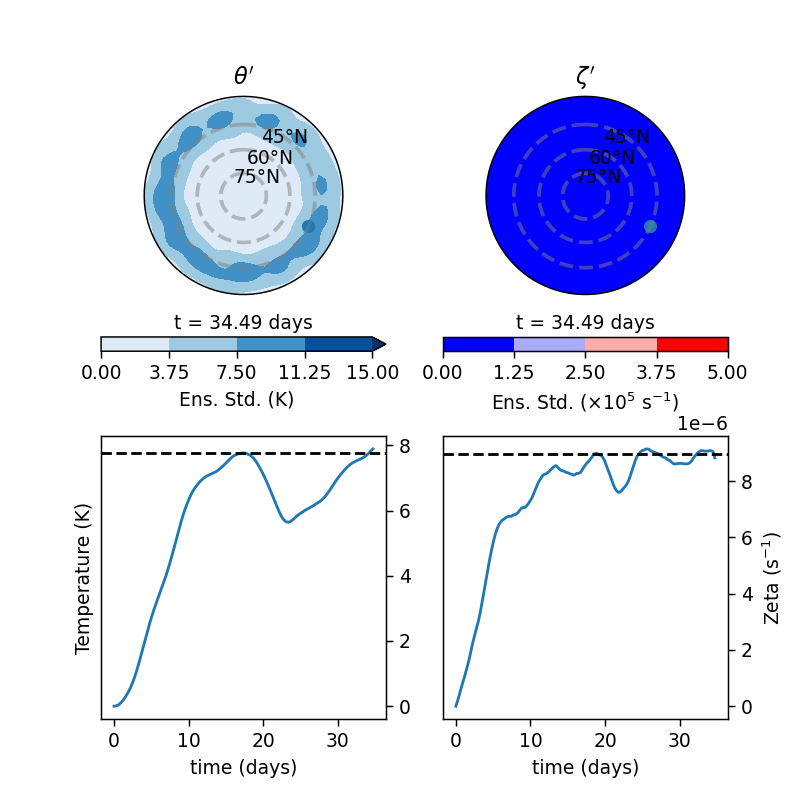

In [16]:
s2d = 1/60./60./24.
fig = plt.figure(figsize=(6,6))
proj=ccrs.NorthPolarStereo()
xy=(65,45)
levels = [np.linspace(0,15,5), np.linspace(0,5,5)]
ax1 = plt.subplot(2,2,1, projection = proj) #axes for map
ax2 = plt.subplot(2,2,2, projection = proj)
ax3 = plt.subplot(2,2,3)#axes for discrete point
ax4 = plt.subplot(2,2,4)

plotters.plot_theta_ensspread(ensemble.isel(time=tidx), ax=ax1, levels=levels[0])
ax1.scatter(x=xy[0], y=xy[1], transform = ccrs.PlateCarree())

plotters.plot_zeta_ensspread(ensemble.isel(time=tidx), ax=ax2, levels=levels[1])
ax2.scatter(x=xy[0], y=xy[1], transform = ccrs.PlateCarree())

ax3.plot(ensemble.time*s2d, ensemble.theta.sel(x=xy[0], y=xy[1], method='nearest').std('ens_mem'))
ax4.plot(ensemble.time*s2d, ensemble.vortp.sel(x=xy[0], y=xy[1], method='nearest').std('ens_mem'))

ax3.axhline(clims.thetap.sel(y=xy[1], method='nearest').values,0,1, color = 'k', linestyle = '--')
ax4.axhline(clims.vort.sel(y=xy[1], method='nearest').values,0,1, color = 'k', linestyle = '--')

ax3.yaxis.tick_right()
ax3.set_xlabel('time (days)')
ax3.set_ylabel('Temperature (K)')


ax4.yaxis.tick_right()
ax4.set_xlabel('time (days)')
ax4.set_ylabel(r'Zeta (s$^{-1}$)')
ax4.yaxis.set_label_position("right")

In [28]:
(1+1j*5)*(1-np.exp(-0.005))

(0.00498752080731768+0.0249376040365884j)

# Enough ens members?

In [7]:
dt = 4000 #time between integration steps (seconds)
nlat=64; nlon=128

Nt = 100000 #number of integration steps
T= Nt*dt #total integration time
print('integrating for ', T/86400, ' days, with a dt of ', dt/86400, ' days')
#fclim=ensemble_methods.generate_ensemble_forcing(nlat, nlon, dt, T,  n_ens =  1)


num_members= 500 #num of members in the ensemble
Nt = 100 #number of integration steps
T= Nt*dt #total integration time
print('integrating for ', T/86400, ' days, with a dt of ', dt/86400, ' days')

f=ensemble_methods.generate_ensemble_forcing(nlat, nlon, dt, T,  n_ens =  num_members)



integrating for  4629.62962962963  days, with a dt of  0.046296296296296294  days
integrating for  4.62962962962963  days, with a dt of  0.046296296296296294  days


100%|█████████████████████████████████████████| 500/500 [00:21<00:00, 23.46it/s]


<IPython.core.display.Javascript object>


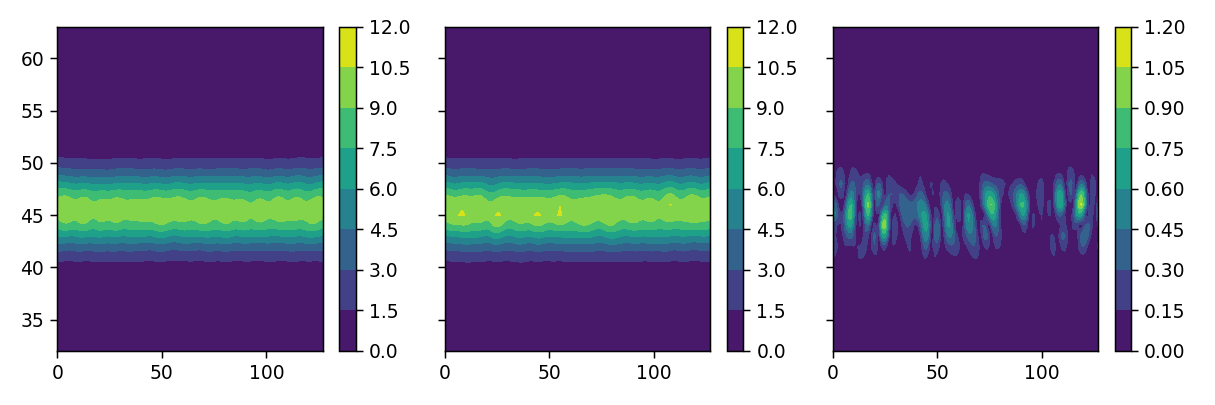

In [8]:
fig, axs= plt.subplots(1,3, figsize=(9,3), sharey=True,sharex=True)


cf=axs[0].contourf(fclim[0].std(axis=0))
plt.colorbar(cf,ax=axs[0])

cf=axs[1].contourf(f[:,-5,:,:].std(axis=0))
plt.colorbar(cf,ax=axs[1])

cf=axs[2].contourf(abs(fclim[0].std(axis=0)-f[:,-5,:,:].std(axis=0)))
plt.colorbar(cf,ax=axs[2])


#cf2 = plt.contourf
#f[:,-5,:,:].std(axis=0).mean(axis=-1))
plt.ylim(32,63)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


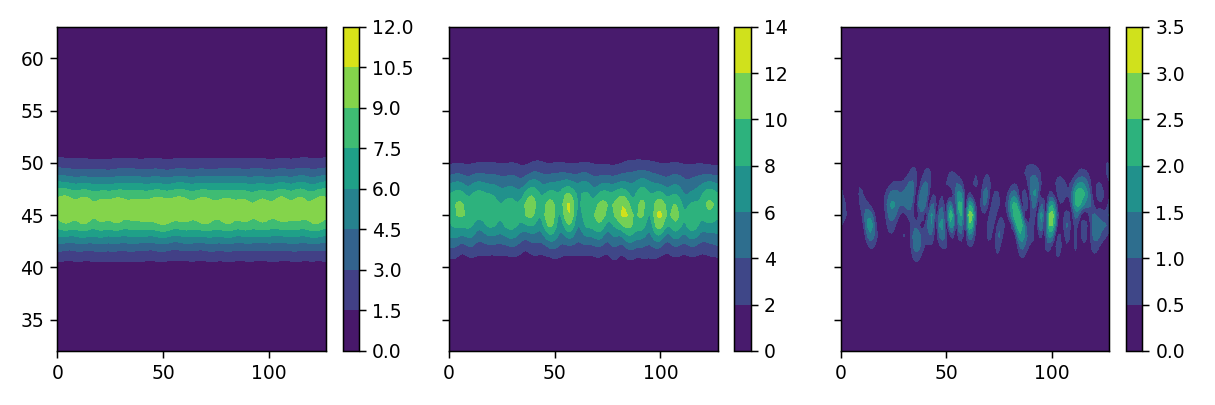

In [3]:
fig, axs= plt.subplots(1,3, figsize=(9,3), sharey=True,sharex=True)


cf=axs[0].contourf(fclim[0].std(axis=0))
plt.colorbar(cf,ax=axs[0])

cf=axs[1].contourf(f[:,-5,:,:].std(axis=0))
plt.colorbar(cf,ax=axs[1])

cf=axs[2].contourf(abs(fclim[0].std(axis=0)-f[:,-5,:,:].std(axis=0)))
plt.colorbar(cf,ax=axs[2])


#cf2 = plt.contourf
#f[:,-5,:,:].std(axis=0).mean(axis=-1))
plt.ylim(32,63)
plt.tight_layout()
plt.show()

In [18]:
f[:,-5,:,:].mean(axis=-1).shape

(50, 64)

# check no spatial preference

In [4]:
from tqdm import tqdm
dt = 4000 #time between integration steps (seconds)
Nt = 7884//6 #number of integration steps (7884 = 1 yr)
T= Nt*dt #total integration time
print('integrating for ', T/86400, ' days, with a dt of ', dt/86400, ' days')

ofreq = 2
nr = 100
ll = 15

#T42 resolution
nlat=64; nlon=128
vort_std = np.empty((nr,nlon))
thet_std = np.empty((nr,nlon))

for nn in tqdm(range(nr)):
    st = Sphere(nlat,nlon, U=0.)
    F = Forcing(st,dt,T)
    Si=F.generate_rededdy_start()
    F.generate_rededdy_tseries(A=5e-12,Si=Si)

    k0=6
    vortp = 10e-5 * np.exp( -0.5 * (st.glats - 20.)**2 / 10**2 ) * np.cos(k0 * st.rlons)
    thetap = np.zeros(vortp.shape)
    vortp = np.zeros(thetap.shape)
    ics = np.array([vortp,thetap])


    sln = Solver(st, forcing=F, ofreq=ofreq).integrate_dynamics(temp_linear=True, vort_linear=True)
    vort_std[nn,:] = sln.vort.isel(y=ll).std('time')
    thet_std[nn,:] = sln.theta.isel(y=ll).std('time')

integrating for  60.833333333333336  days, with a dt of  0.046296296296296294  days


100%|█████████████████████████████████████████| 100/100 [06:45<00:00,  4.05s/it]


<IPython.core.display.Javascript object>


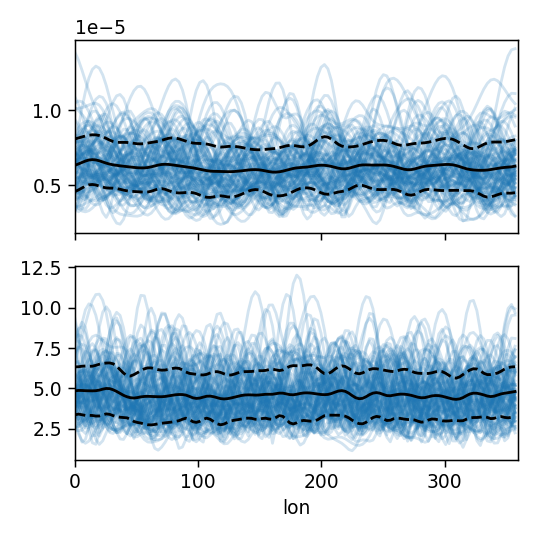

In [7]:
fig,axs = plt.subplots(2,1, figsize=(4,4), sharex=True)
for nn in range(nr):
    axs[0].plot(sln.x.values,vort_std[nn], color = 'tab:blue',alpha=0.2)
    axs[1].plot(sln.x.values,thet_std[nn], color = 'tab:blue',alpha=0.2)
axs[0].plot(sln.x.values,vort_std.mean(axis=0), color = 'k')
axs[0].plot(sln.x.values,vort_std.mean(axis=0)+vort_std.std(axis=0), color='k', linestyle='--')
axs[0].plot(sln.x.values,vort_std.mean(axis=0)-vort_std.std(axis=0), color='k', linestyle='--')


axs[1].plot(sln.x.values,thet_std.mean(axis=0), color = 'k')
axs[1].plot(sln.x.values,thet_std.mean(axis=0)+thet_std.std(axis=0), color='k', linestyle='--')
axs[1].plot(sln.x.values,thet_std.mean(axis=0)-thet_std.std(axis=0), color='k', linestyle='--')

plt.xlim(0,360)
plt.xlabel('lon')

plt.tight_layout()
plt.show()

# Just the red noise for a long time

In [17]:
dt = 4000 #time between integration steps (seconds)
Nt = 5000 #number of integration steps
T= Nt*dt #total integration time
print('integrating for ', T/86400, ' days, with a dt of ', dt/86400, ' days')

ofreq = 2

#T42 resolution
nlat=64; nlon=128
#nlat = 32; nlon=64
#U= 10*np.cos(st.rlats)

st = Sphere(nlat,nlon, U=0.)
#st.gaussian_jet()
F = Forcing(st,dt,T)
#F.generate_rededdy_tseries(A=1e-11)
#print(forcing_tseries)
a,b= F.generate_rededdy_tseries(A=5e-12)

integrating for  23148.14814814815  days, with a dt of  0.046296296296296294  days
(64, 128)


<IPython.core.display.Javascript object>


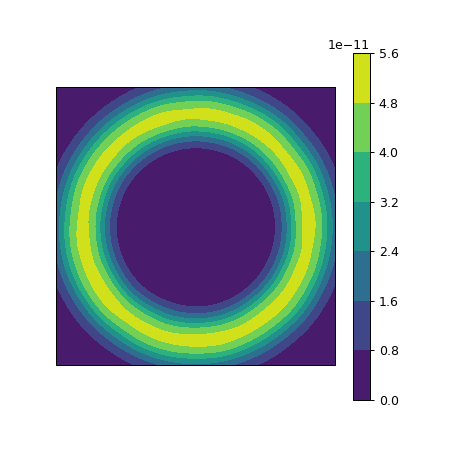

In [18]:
f = plt.figure(figsize = (5, 5))

proj=ccrs.NorthPolarStereo()
ax = plt.axes(projection=proj)
ax.set_extent([-179.9, 179.9, 30, 90], crs=ccrs.PlateCarree())
    
cyclic_data, cyclic_lons = cartopy.util.add_cyclic_point(np.std(a,axis=0),sln.x.values)
cf= ax.contourf(cyclic_lons,sln.y.values, cyclic_data, transform=ccrs.PlateCarree())

plt.colorbar(cf)
plt.show()

<IPython.core.display.Javascript object>


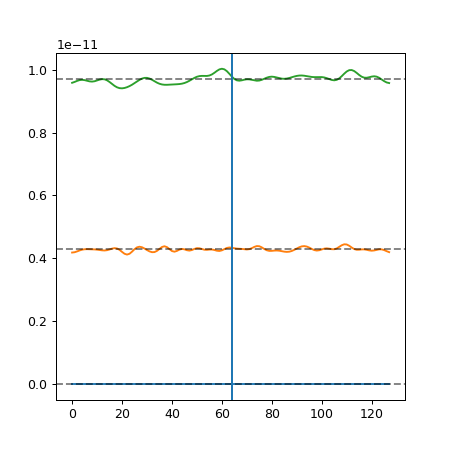

In [19]:
f = plt.figure(figsize = (5, 5))

lats = [32,40,50]
for ll in lats:
    plt.plot(a[:,ll,:].std(axis=0))
    plt.axhline(a[:,ll,:].std(axis=0).mean(), linestyle='--', color='k',alpha=0.5)
    plt.axvline(128/2)


<IPython.core.display.Javascript object>


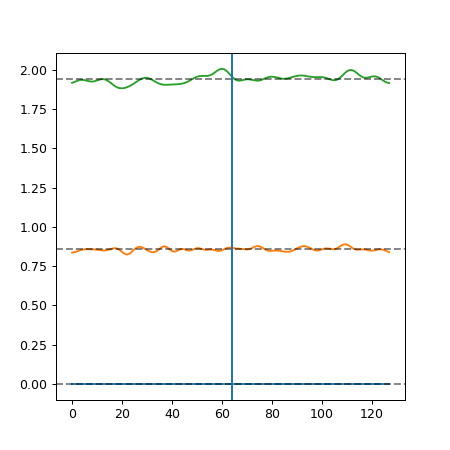

In [20]:
f = plt.figure(figsize = (5, 5))

lats = [32,40,50]
for ll in lats:
    plt.plot(b[:,ll,:].std(axis=0))
    plt.axhline(b[:,ll,:].std(axis=0).mean(), linestyle='--', color='k',alpha=0.5)
    plt.axvline(128/2)
